# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [32]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [33]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [34]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [35]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer=input_layer, filters=filters, strides=strides)

    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [36]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upscaled = bilinear_upsample(input_layer=small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    larger = layers.concatenate([upscaled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(input_layer=larger, filters=filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [37]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
#     encoding_layer1 = encoder_block(input_layer=inputs, filters=32, strides=2)
#     encoding_layer2 = encoder_block(input_layer=encoding_layer1, filters=128, strides=2)


    encoding_layer1 = encoder_block(input_layer=inputs, filters=64, strides=2)
    encoding_layer2 = encoder_block(input_layer=encoding_layer1, filters=128, strides=2)
    encoding_layer3 = encoder_block(input_layer=encoding_layer2, filters=512, strides=2)




    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    con1x = conv2d_batchnorm(input_layer=encoding_layer3, filters=1024, kernel_size=1, strides=1)
#     con2x = conv2d_batchnorm(input_layer=con1x, filters=256, kernel_size=1, strides=1)
    
#     con3x = conv2d_batchnorm(input_layer=con2x, filters=64, kernel_size=1, strides=1)
#     con4x = conv2d_batchnorm(input_layer=con3x, filters=64, kernel_size=1, strides=1)
#     con5x = conv2d_batchnorm(input_layer=con4x, filters=64, kernel_size=1, strides=1)


    
#     con1x = conv2d_batchnorm(input_layer=encoding_layer4, filters=512, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #     decoding_layer1=decoder_block(small_ip_layer=decoding_layer2, large_ip_layer=encoding_layer1, filters=16)
#     decoding_layer1=decoder_block(small_ip_layer=con5x, large_ip_layer=encoding_layer1, filters=128)
#     x=decoder_block(small_ip_layer=decoding_layer1 , large_ip_layer=inputs , filters=32)

    
    decoding_layer3=decoder_block(small_ip_layer=con1x, large_ip_layer=encoding_layer2, filters=512)
    decoding_layer2=decoder_block(small_ip_layer=decoding_layer3, large_ip_layer=encoding_layer1, filters=128)
    x=decoder_block(small_ip_layer=decoding_layer2, large_ip_layer=inputs, filters=64)

   
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [39]:
learning_rate = 0.001
batch_size = 32
num_epochs = 90
steps_per_epoch = 200
validation_steps = 50
workers = 2

# learning_rate = 
# batch_size = 0
# num_epochs = 0
# steps_per_epoch = 200
# validation_steps = 50
# workers = 2

Epoch 1/90
199/200 [============================>.] - ETA: 0s - loss: 0.4351

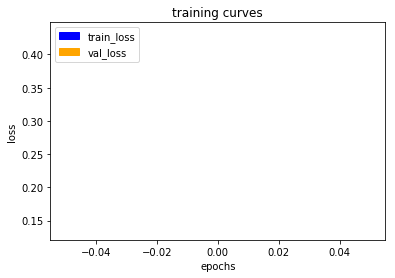

200/200 [==============================] - 150s - loss: 0.4334 - val_loss: 0.1361
Epoch 2/90
199/200 [============================>.] - ETA: 0s - loss: 0.0517

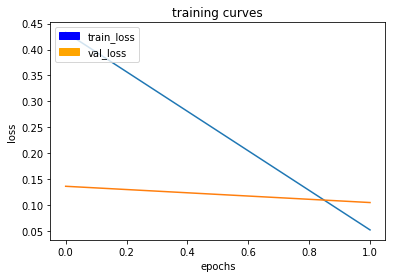

200/200 [==============================] - 152s - loss: 0.0518 - val_loss: 0.1047
Epoch 3/90
199/200 [============================>.] - ETA: 0s - loss: 0.0321

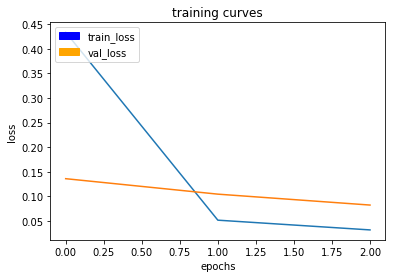

200/200 [==============================] - 152s - loss: 0.0320 - val_loss: 0.0825
Epoch 4/90
199/200 [============================>.] - ETA: 0s - loss: 0.0267

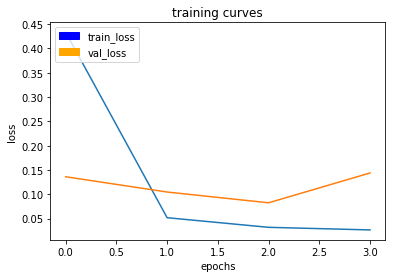

200/200 [==============================] - 152s - loss: 0.0267 - val_loss: 0.1439
Epoch 5/90
199/200 [============================>.] - ETA: 0s - loss: 0.0243

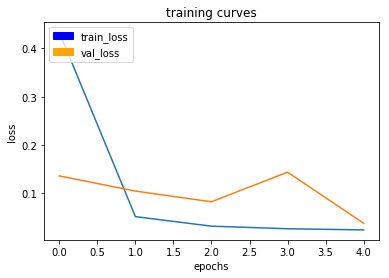

200/200 [==============================] - 152s - loss: 0.0243 - val_loss: 0.0380
Epoch 6/90
199/200 [============================>.] - ETA: 0s - loss: 0.0208

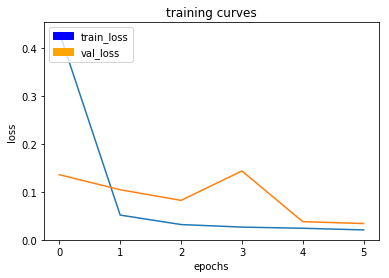

200/200 [==============================] - 151s - loss: 0.0208 - val_loss: 0.0342
Epoch 7/90
199/200 [============================>.] - ETA: 0s - loss: 0.0193

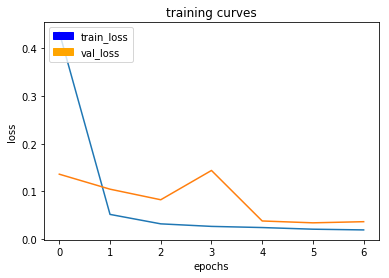

200/200 [==============================] - 151s - loss: 0.0193 - val_loss: 0.0366
Epoch 8/90
199/200 [============================>.] - ETA: 0s - loss: 0.0180

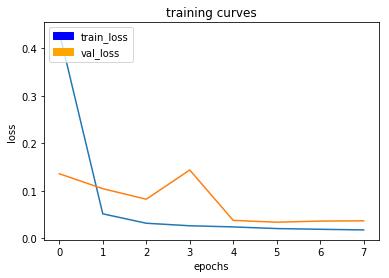

200/200 [==============================] - 151s - loss: 0.0180 - val_loss: 0.0371
Epoch 9/90
199/200 [============================>.] - ETA: 0s - loss: 0.0183

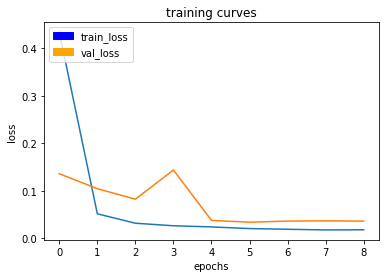

200/200 [==============================] - 152s - loss: 0.0183 - val_loss: 0.0365
Epoch 10/90
199/200 [============================>.] - ETA: 0s - loss: 0.0184

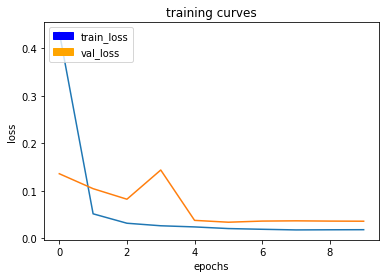

200/200 [==============================] - 151s - loss: 0.0184 - val_loss: 0.0363
Epoch 11/90
199/200 [============================>.] - ETA: 0s - loss: 0.0157

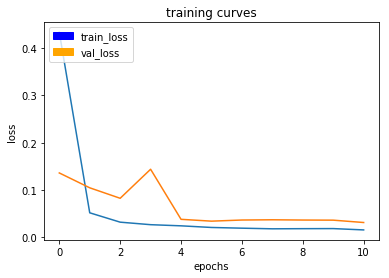

200/200 [==============================] - 152s - loss: 0.0157 - val_loss: 0.0313
Epoch 12/90
199/200 [============================>.] - ETA: 0s - loss: 0.0147

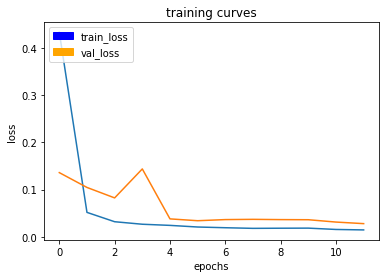

200/200 [==============================] - 152s - loss: 0.0147 - val_loss: 0.0280
Epoch 13/90
199/200 [============================>.] - ETA: 0s - loss: 0.0158

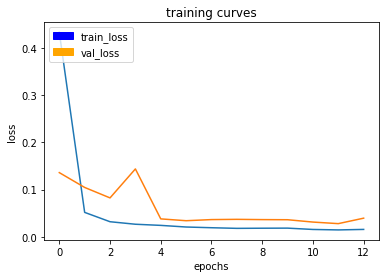

200/200 [==============================] - 151s - loss: 0.0157 - val_loss: 0.0396
Epoch 14/90
199/200 [============================>.] - ETA: 0s - loss: 0.0158

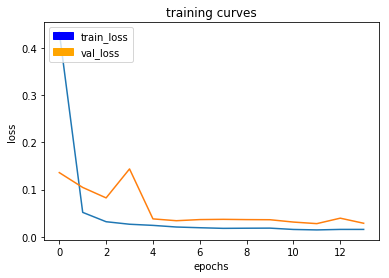

200/200 [==============================] - 152s - loss: 0.0158 - val_loss: 0.0288
Epoch 15/90
199/200 [============================>.] - ETA: 0s - loss: 0.0136

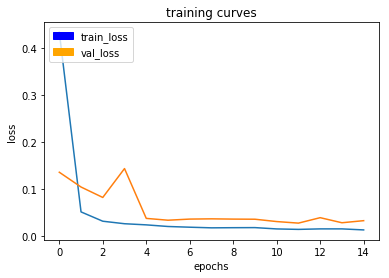

200/200 [==============================] - 150s - loss: 0.0136 - val_loss: 0.0332
Epoch 16/90
199/200 [============================>.] - ETA: 0s - loss: 0.0154

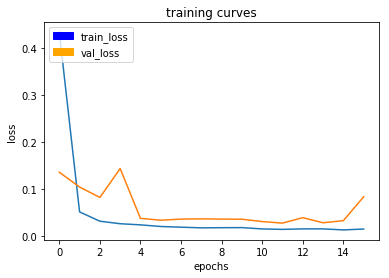

200/200 [==============================] - 152s - loss: 0.0154 - val_loss: 0.0839
Epoch 17/90
199/200 [============================>.] - ETA: 0s - loss: 0.0143

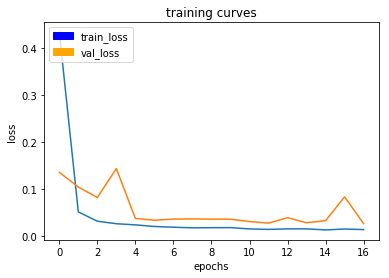

200/200 [==============================] - 152s - loss: 0.0143 - val_loss: 0.0267
Epoch 18/90
199/200 [============================>.] - ETA: 0s - loss: 0.0141

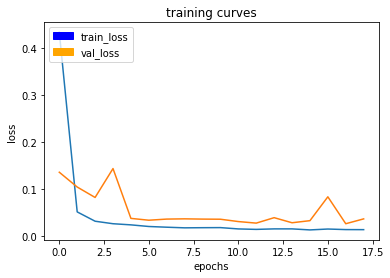

200/200 [==============================] - 152s - loss: 0.0141 - val_loss: 0.0370
Epoch 19/90
199/200 [============================>.] - ETA: 0s - loss: 0.0124

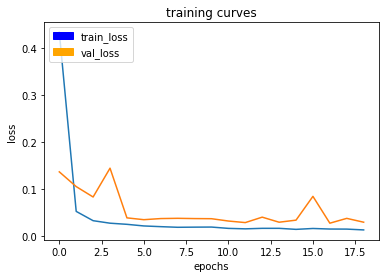

200/200 [==============================] - 152s - loss: 0.0124 - val_loss: 0.0288
Epoch 20/90
199/200 [============================>.] - ETA: 0s - loss: 0.0147

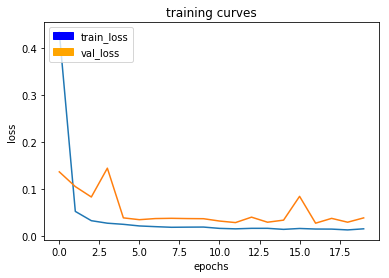

200/200 [==============================] - 152s - loss: 0.0147 - val_loss: 0.0380
Epoch 21/90
199/200 [============================>.] - ETA: 0s - loss: 0.0127

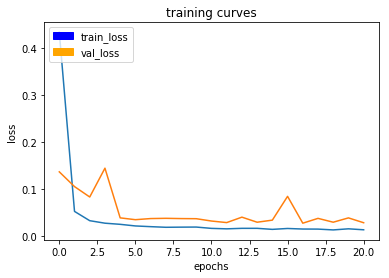

200/200 [==============================] - 151s - loss: 0.0127 - val_loss: 0.0277
Epoch 22/90
199/200 [============================>.] - ETA: 0s - loss: 0.0128

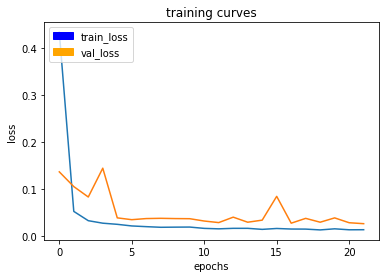

200/200 [==============================] - 152s - loss: 0.0128 - val_loss: 0.0257
Epoch 23/90
199/200 [============================>.] - ETA: 0s - loss: 0.0123

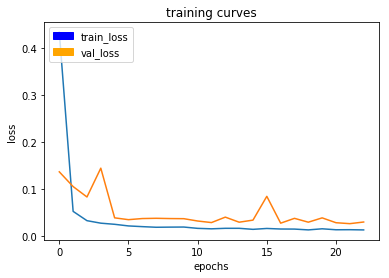

200/200 [==============================] - 152s - loss: 0.0123 - val_loss: 0.0292
Epoch 24/90
199/200 [============================>.] - ETA: 0s - loss: 0.0115

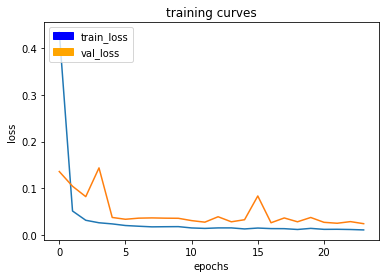

200/200 [==============================] - 152s - loss: 0.0115 - val_loss: 0.0248
Epoch 25/90
199/200 [============================>.] - ETA: 0s - loss: 0.0113

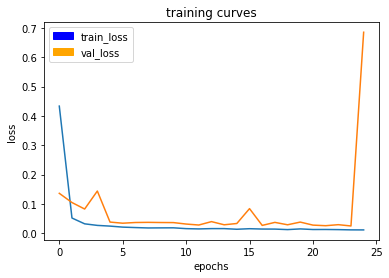

200/200 [==============================] - 152s - loss: 0.0113 - val_loss: 0.6853
Epoch 26/90
199/200 [============================>.] - ETA: 0s - loss: 0.0118

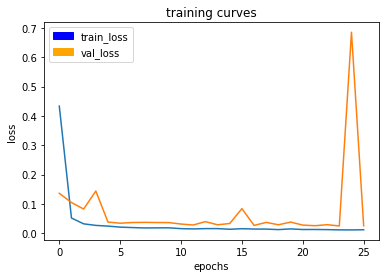

200/200 [==============================] - 152s - loss: 0.0118 - val_loss: 0.0254
Epoch 27/90
199/200 [============================>.] - ETA: 0s - loss: 0.0105

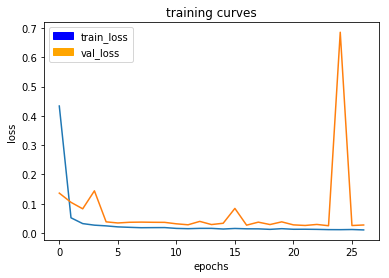

200/200 [==============================] - 152s - loss: 0.0105 - val_loss: 0.0273
Epoch 28/90
199/200 [============================>.] - ETA: 0s - loss: 0.0111

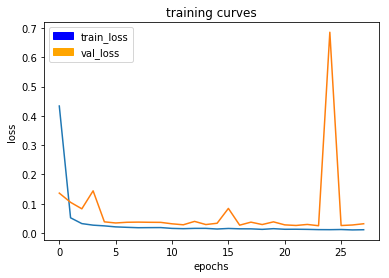

200/200 [==============================] - 151s - loss: 0.0111 - val_loss: 0.0315
Epoch 29/90
199/200 [============================>.] - ETA: 0s - loss: 0.0118

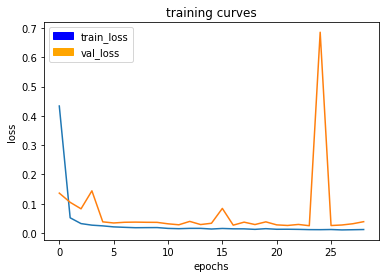

200/200 [==============================] - 152s - loss: 0.0118 - val_loss: 0.0386
Epoch 30/90
199/200 [============================>.] - ETA: 0s - loss: 0.0115

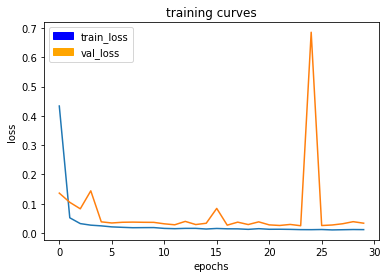

200/200 [==============================] - 151s - loss: 0.0115 - val_loss: 0.0334
Epoch 31/90
199/200 [============================>.] - ETA: 0s - loss: 0.0102

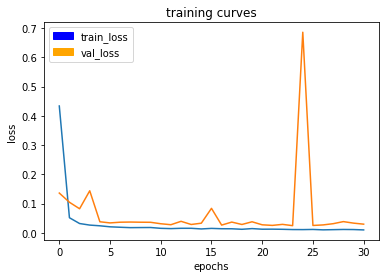

200/200 [==============================] - 152s - loss: 0.0102 - val_loss: 0.0299
Epoch 32/90
199/200 [============================>.] - ETA: 0s - loss: 0.0095

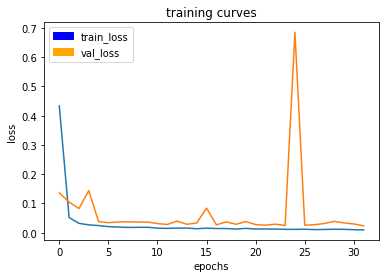

200/200 [==============================] - 151s - loss: 0.0095 - val_loss: 0.0233
Epoch 33/90
199/200 [============================>.] - ETA: 0s - loss: 0.0103

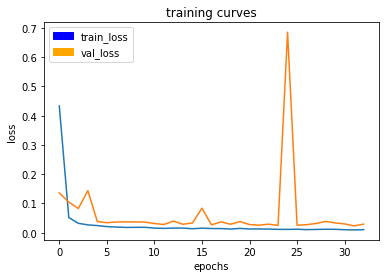

200/200 [==============================] - 152s - loss: 0.0103 - val_loss: 0.0293
Epoch 34/90
199/200 [============================>.] - ETA: 0s - loss: 0.0100

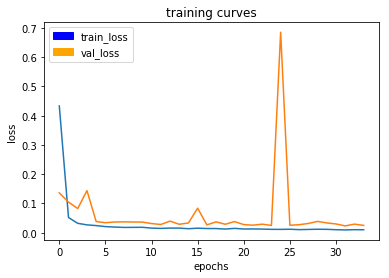

200/200 [==============================] - 151s - loss: 0.0100 - val_loss: 0.0250
Epoch 35/90
199/200 [============================>.] - ETA: 0s - loss: 0.0091

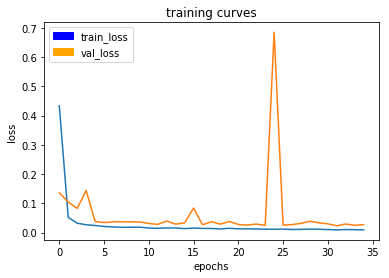

200/200 [==============================] - 152s - loss: 0.0091 - val_loss: 0.0273
Epoch 36/90
199/200 [============================>.] - ETA: 0s - loss: 0.0085

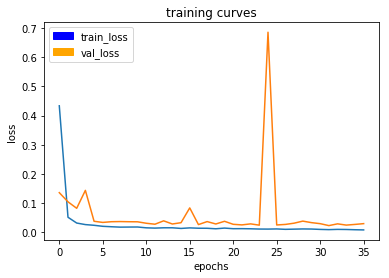

200/200 [==============================] - 152s - loss: 0.0085 - val_loss: 0.0300
Epoch 37/90
199/200 [============================>.] - ETA: 0s - loss: 0.0122

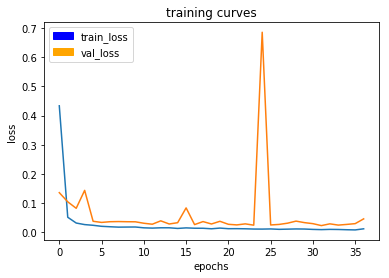

200/200 [==============================] - 151s - loss: 0.0122 - val_loss: 0.0463
Epoch 38/90
199/200 [============================>.] - ETA: 0s - loss: 0.0132

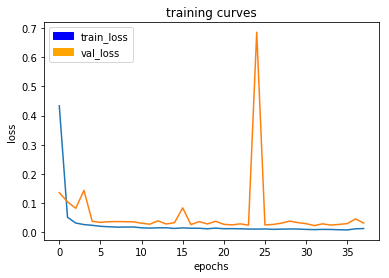

200/200 [==============================] - 152s - loss: 0.0132 - val_loss: 0.0318
Epoch 39/90
199/200 [============================>.] - ETA: 0s - loss: 0.0111

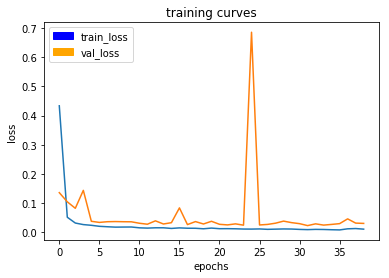

200/200 [==============================] - 151s - loss: 0.0111 - val_loss: 0.0308
Epoch 40/90
199/200 [============================>.] - ETA: 0s - loss: 0.0092

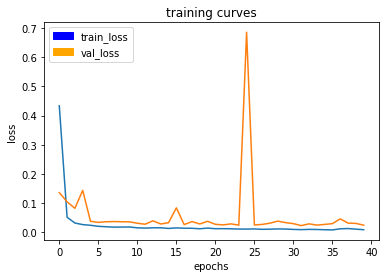

200/200 [==============================] - 152s - loss: 0.0092 - val_loss: 0.0248
Epoch 41/90
199/200 [============================>.] - ETA: 0s - loss: 0.0094

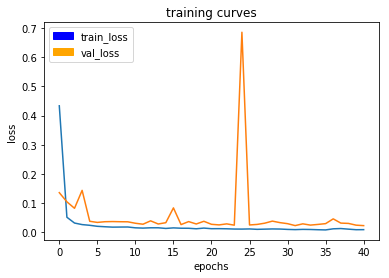

200/200 [==============================] - 151s - loss: 0.0094 - val_loss: 0.0232
Epoch 42/90
199/200 [============================>.] - ETA: 0s - loss: 0.0085

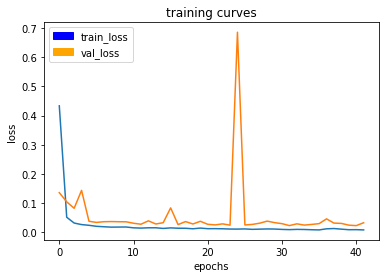

200/200 [==============================] - 152s - loss: 0.0085 - val_loss: 0.0331
Epoch 43/90
199/200 [============================>.] - ETA: 0s - loss: 0.0093

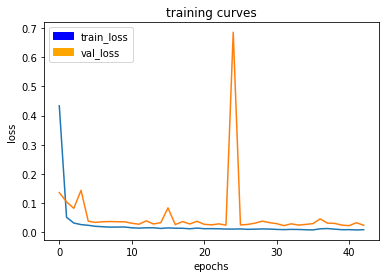

200/200 [==============================] - 151s - loss: 0.0093 - val_loss: 0.0245
Epoch 44/90
199/200 [============================>.] - ETA: 0s - loss: 0.0084

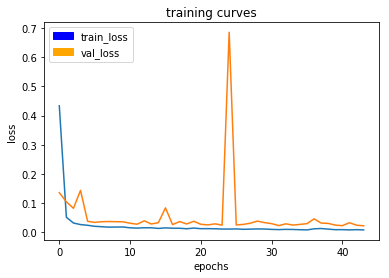

200/200 [==============================] - 152s - loss: 0.0084 - val_loss: 0.0226
Epoch 45/90
199/200 [============================>.] - ETA: 0s - loss: 0.0076

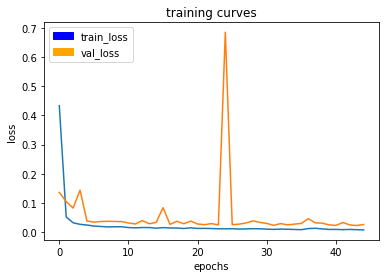

200/200 [==============================] - 151s - loss: 0.0076 - val_loss: 0.0262
Epoch 46/90
199/200 [============================>.] - ETA: 0s - loss: 0.0084

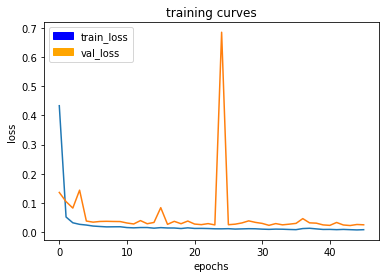

200/200 [==============================] - 151s - loss: 0.0084 - val_loss: 0.0251
Epoch 47/90
199/200 [============================>.] - ETA: 0s - loss: 0.0075

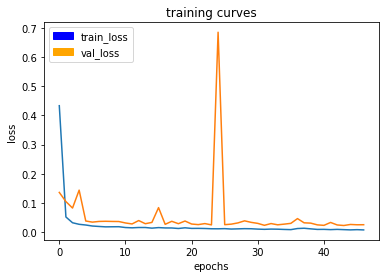

200/200 [==============================] - 152s - loss: 0.0075 - val_loss: 0.0253
Epoch 48/90
199/200 [============================>.] - ETA: 0s - loss: 0.0077

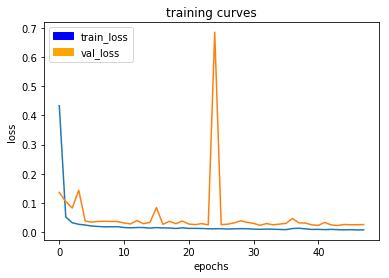

200/200 [==============================] - 152s - loss: 0.0077 - val_loss: 0.0258
Epoch 49/90
199/200 [============================>.] - ETA: 0s - loss: 0.0095

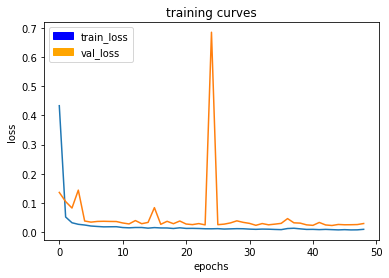

200/200 [==============================] - 152s - loss: 0.0095 - val_loss: 0.0294
Epoch 50/90
199/200 [============================>.] - ETA: 0s - loss: 0.0079

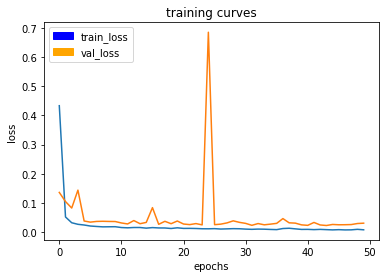

200/200 [==============================] - 152s - loss: 0.0079 - val_loss: 0.0306
Epoch 51/90
199/200 [============================>.] - ETA: 0s - loss: 0.0074

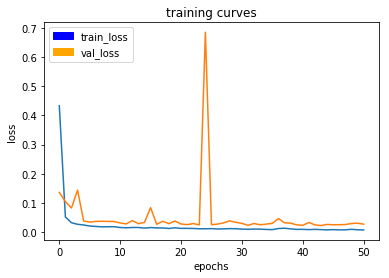

200/200 [==============================] - 152s - loss: 0.0074 - val_loss: 0.0271
Epoch 52/90
199/200 [============================>.] - ETA: 0s - loss: 0.0086

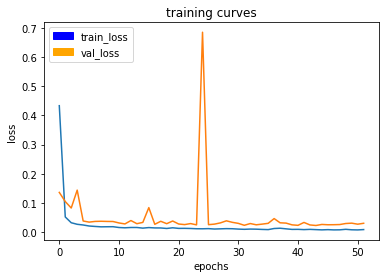

200/200 [==============================] - 151s - loss: 0.0086 - val_loss: 0.0302
Epoch 53/90
199/200 [============================>.] - ETA: 0s - loss: 0.0093

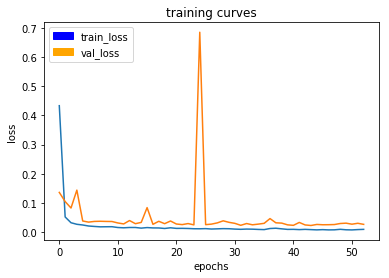

200/200 [==============================] - 152s - loss: 0.0093 - val_loss: 0.0265
Epoch 54/90
199/200 [============================>.] - ETA: 0s - loss: 0.0076

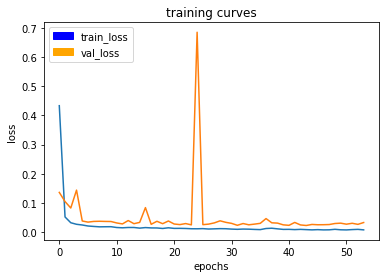

200/200 [==============================] - 151s - loss: 0.0076 - val_loss: 0.0328
Epoch 55/90
199/200 [============================>.] - ETA: 0s - loss: 0.0091

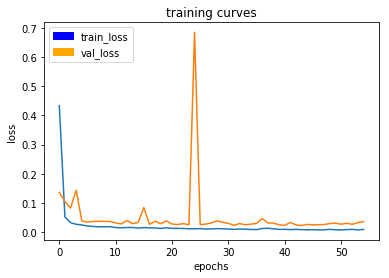

200/200 [==============================] - 152s - loss: 0.0091 - val_loss: 0.0359
Epoch 56/90
199/200 [============================>.] - ETA: 0s - loss: 0.0080

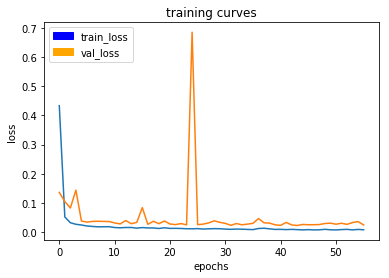

200/200 [==============================] - 151s - loss: 0.0080 - val_loss: 0.0244
Epoch 57/90
199/200 [============================>.] - ETA: 0s - loss: 0.0081

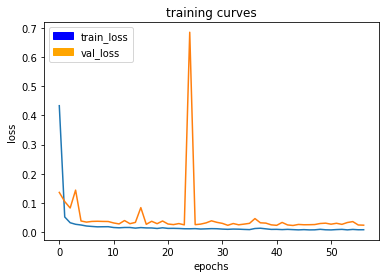

200/200 [==============================] - 152s - loss: 0.0081 - val_loss: 0.0237
Epoch 58/90
199/200 [============================>.] - ETA: 0s - loss: 0.0070

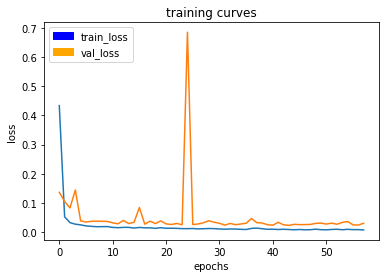

200/200 [==============================] - 153s - loss: 0.0070 - val_loss: 0.0299
Epoch 59/90
199/200 [============================>.] - ETA: 0s - loss: 0.0078

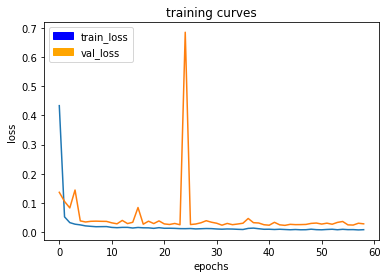

200/200 [==============================] - 152s - loss: 0.0078 - val_loss: 0.0279
Epoch 60/90
199/200 [============================>.] - ETA: 0s - loss: 0.0068

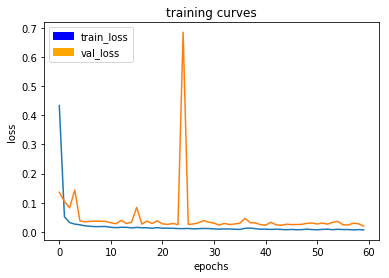

200/200 [==============================] - 152s - loss: 0.0068 - val_loss: 0.0200
Epoch 61/90
199/200 [============================>.] - ETA: 0s - loss: 0.0077

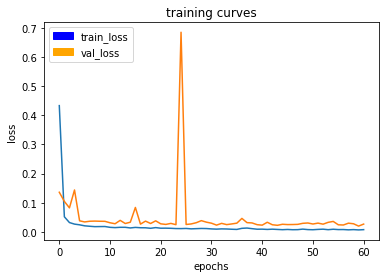

200/200 [==============================] - 152s - loss: 0.0077 - val_loss: 0.0268
Epoch 62/90
199/200 [============================>.] - ETA: 0s - loss: 0.0082

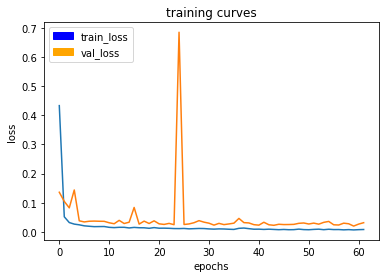

200/200 [==============================] - 152s - loss: 0.0082 - val_loss: 0.0316
Epoch 63/90
199/200 [============================>.] - ETA: 0s - loss: 0.0075

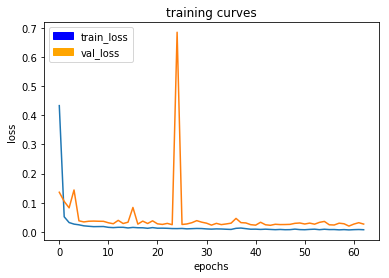

200/200 [==============================] - 152s - loss: 0.0074 - val_loss: 0.0269
Epoch 64/90
199/200 [============================>.] - ETA: 0s - loss: 0.0068

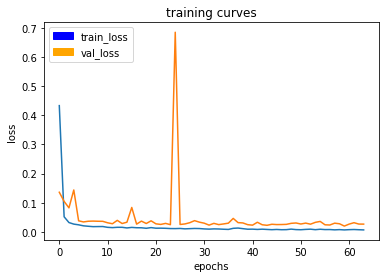

200/200 [==============================] - 152s - loss: 0.0068 - val_loss: 0.0267
Epoch 65/90
199/200 [============================>.] - ETA: 0s - loss: 0.0064

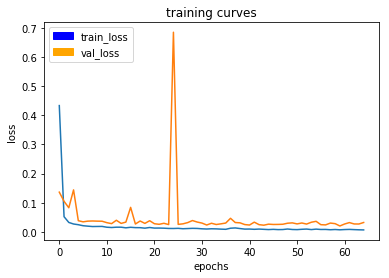

200/200 [==============================] - 151s - loss: 0.0064 - val_loss: 0.0319
Epoch 66/90
199/200 [============================>.] - ETA: 0s - loss: 0.0068

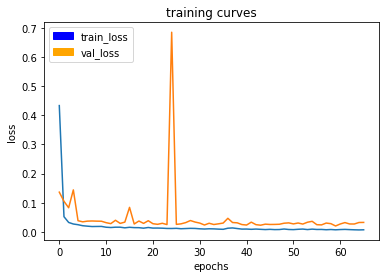

200/200 [==============================] - 152s - loss: 0.0068 - val_loss: 0.0322
Epoch 67/90
199/200 [============================>.] - ETA: 0s - loss: 0.0063

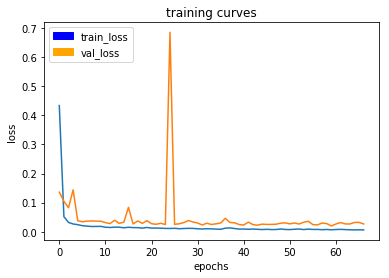

200/200 [==============================] - 151s - loss: 0.0063 - val_loss: 0.0267
Epoch 68/90
199/200 [============================>.] - ETA: 0s - loss: 0.0084

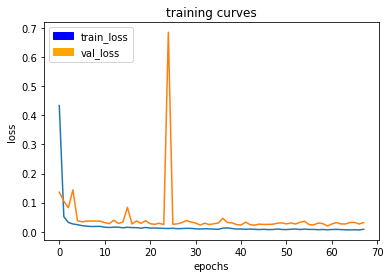

200/200 [==============================] - 151s - loss: 0.0084 - val_loss: 0.0315
Epoch 69/90
199/200 [============================>.] - ETA: 0s - loss: 0.0071

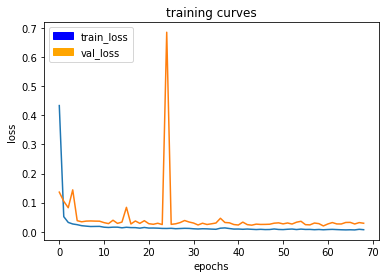

200/200 [==============================] - 151s - loss: 0.0071 - val_loss: 0.0292
Epoch 70/90
199/200 [============================>.] - ETA: 0s - loss: 0.0094

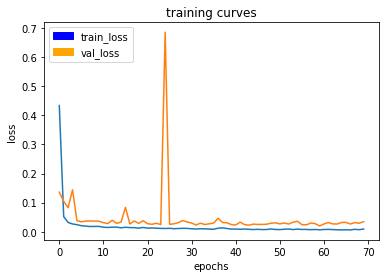

200/200 [==============================] - 151s - loss: 0.0094 - val_loss: 0.0347
Epoch 71/90
199/200 [============================>.] - ETA: 0s - loss: 0.0078

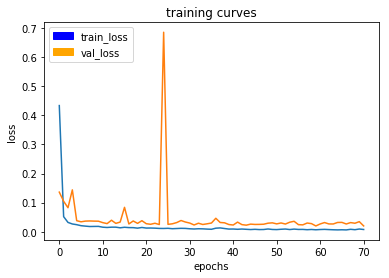

200/200 [==============================] - 152s - loss: 0.0078 - val_loss: 0.0200
Epoch 72/90
199/200 [============================>.] - ETA: 0s - loss: 0.0066

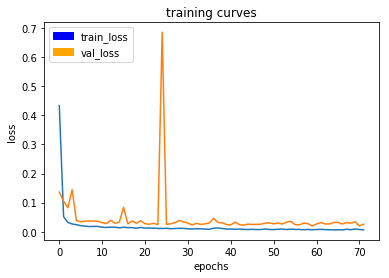

200/200 [==============================] - 151s - loss: 0.0066 - val_loss: 0.0260
Epoch 73/90
199/200 [============================>.] - ETA: 0s - loss: 0.0064

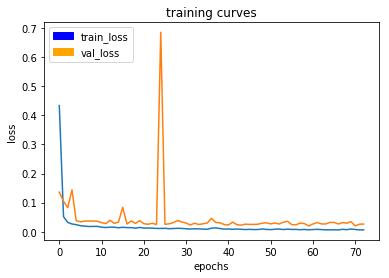

200/200 [==============================] - 151s - loss: 0.0064 - val_loss: 0.0265
Epoch 74/90
199/200 [============================>.] - ETA: 0s - loss: 0.0072

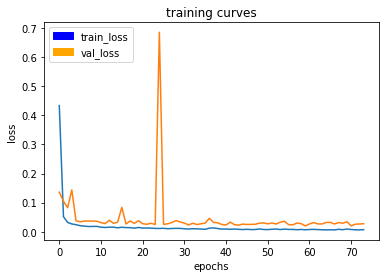

200/200 [==============================] - 151s - loss: 0.0072 - val_loss: 0.0275
Epoch 75/90
199/200 [============================>.] - ETA: 0s - loss: 0.0065

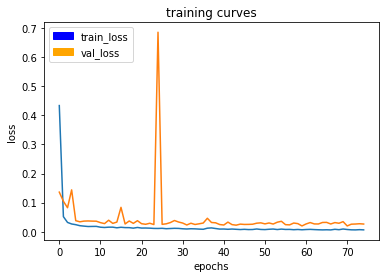

200/200 [==============================] - 152s - loss: 0.0065 - val_loss: 0.0265
Epoch 76/90
199/200 [============================>.] - ETA: 0s - loss: 0.0066

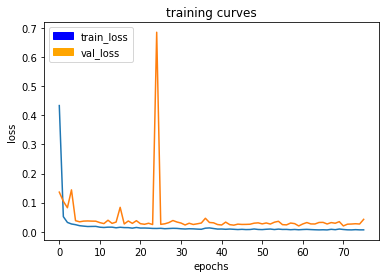

200/200 [==============================] - 151s - loss: 0.0066 - val_loss: 0.0426
Epoch 77/90
199/200 [============================>.] - ETA: 0s - loss: 0.0069

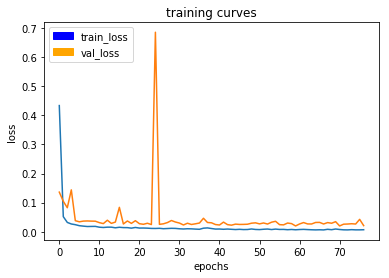

200/200 [==============================] - 152s - loss: 0.0069 - val_loss: 0.0211
Epoch 78/90
199/200 [============================>.] - ETA: 0s - loss: 0.0065

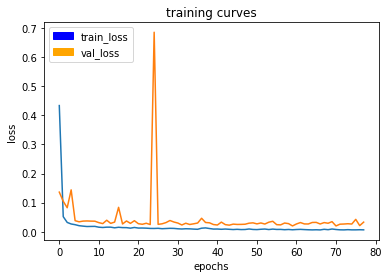

200/200 [==============================] - 151s - loss: 0.0066 - val_loss: 0.0330
Epoch 79/90
199/200 [============================>.] - ETA: 0s - loss: 0.0065

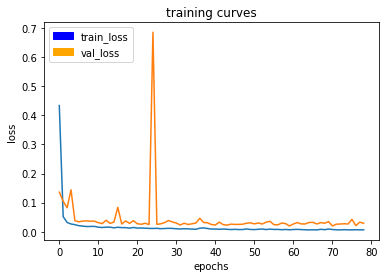

200/200 [==============================] - 151s - loss: 0.0065 - val_loss: 0.0290
Epoch 80/90
199/200 [============================>.] - ETA: 0s - loss: 0.0061

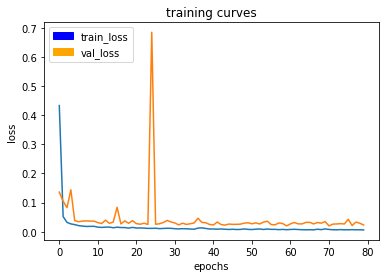

200/200 [==============================] - 151s - loss: 0.0061 - val_loss: 0.0230
Epoch 81/90
199/200 [============================>.] - ETA: 0s - loss: 0.0060

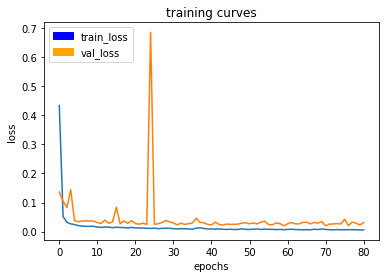

200/200 [==============================] - 152s - loss: 0.0060 - val_loss: 0.0315
Epoch 82/90
199/200 [============================>.] - ETA: 0s - loss: 0.0059

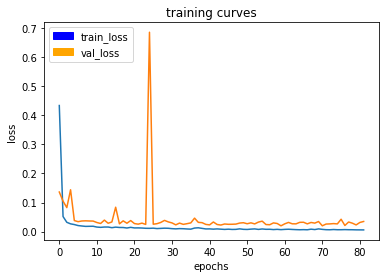

200/200 [==============================] - 151s - loss: 0.0059 - val_loss: 0.0349
Epoch 83/90
199/200 [============================>.] - ETA: 0s - loss: 0.0069

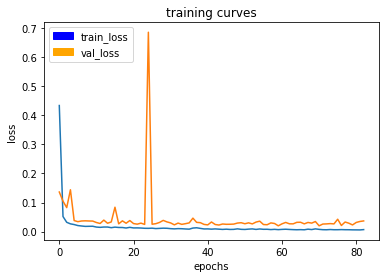

200/200 [==============================] - 151s - loss: 0.0069 - val_loss: 0.0368
Epoch 84/90
199/200 [============================>.] - ETA: 0s - loss: 0.0065

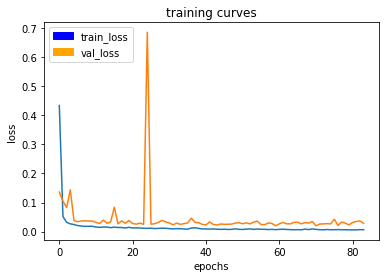

200/200 [==============================] - 152s - loss: 0.0065 - val_loss: 0.0284
Epoch 85/90
199/200 [============================>.] - ETA: 0s - loss: 0.0088

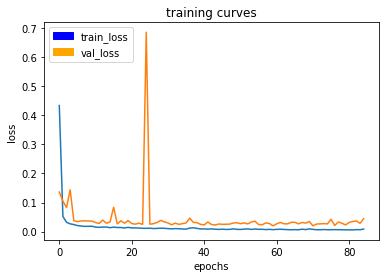

200/200 [==============================] - 151s - loss: 0.0088 - val_loss: 0.0443
Epoch 86/90
199/200 [============================>.] - ETA: 0s - loss: 0.0073

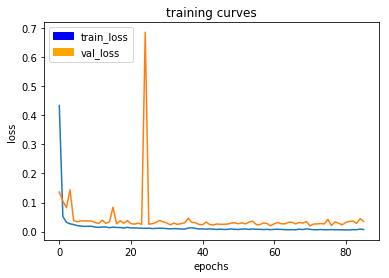

200/200 [==============================] - 152s - loss: 0.0073 - val_loss: 0.0350
Epoch 87/90
199/200 [============================>.] - ETA: 0s - loss: 0.0061

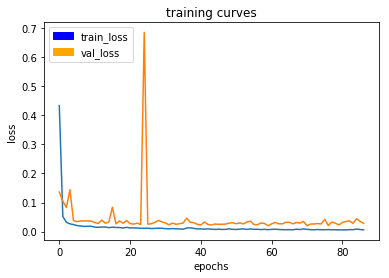

200/200 [==============================] - 152s - loss: 0.0061 - val_loss: 0.0285
Epoch 88/90
199/200 [============================>.] - ETA: 0s - loss: 0.0060

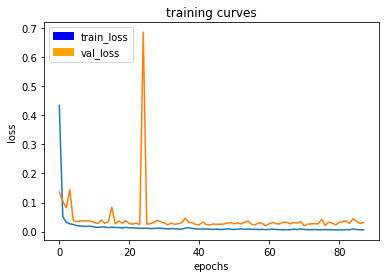

200/200 [==============================] - 152s - loss: 0.0060 - val_loss: 0.0310
Epoch 89/90
199/200 [============================>.] - ETA: 0s - loss: 0.0094

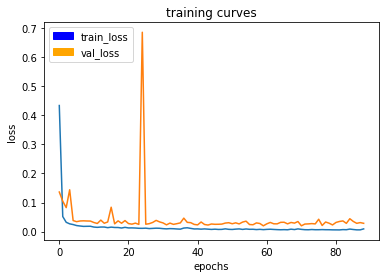

200/200 [==============================] - 151s - loss: 0.0094 - val_loss: 0.0286
Epoch 90/90
199/200 [============================>.] - ETA: 0s - loss: 0.0068

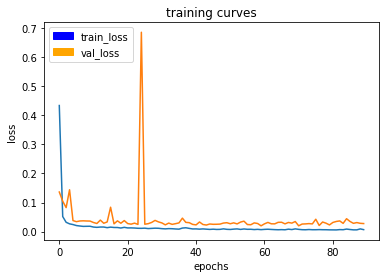

200/200 [==============================] - 152s - loss: 0.0068 - val_loss: 0.0277


In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [41]:
# Save your trained model weights
weight_file_name = 'model_weights-vl'+str(model.history.history['val_loss'][-1])+'-b'+str(batch_size)+'-e'+str(num_epochs)
print(weight_file_name)
model_tools.save_network(model, weight_file_name)

model_weights-vl0.0276947870478-b32-e90


In [42]:
model.history.history['val_loss'][-1]

0.027694787047803402

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [43]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [44]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

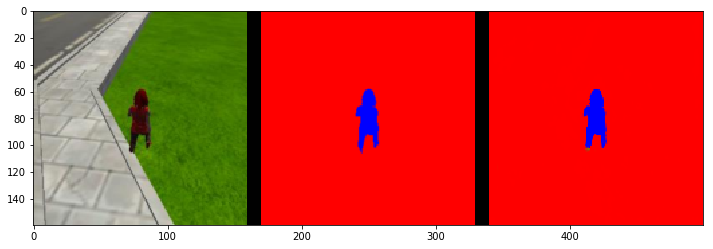

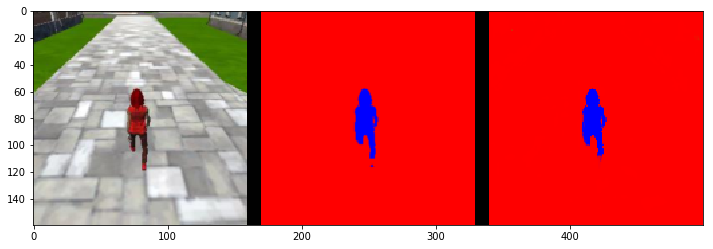

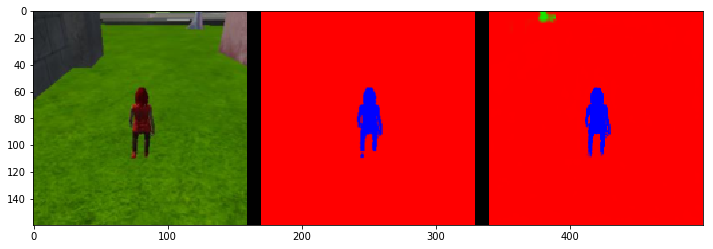

In [45]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

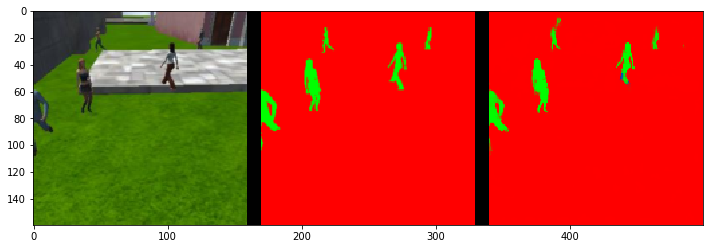

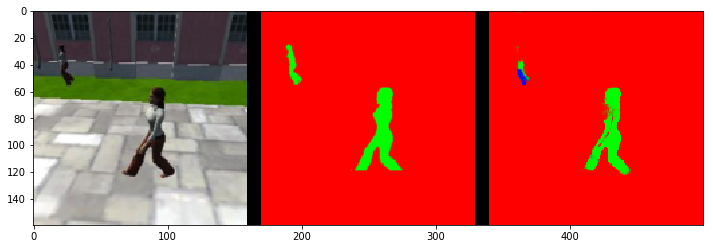

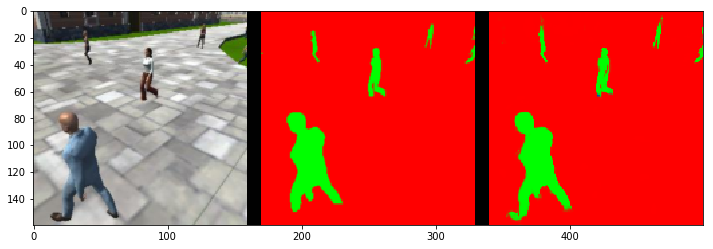

In [46]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

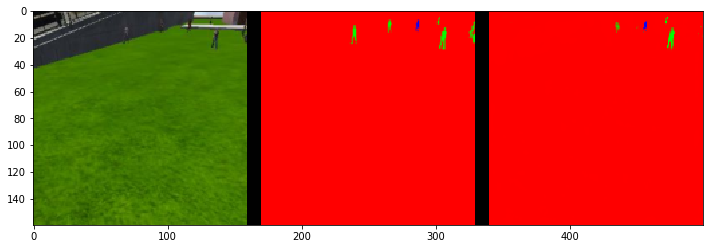

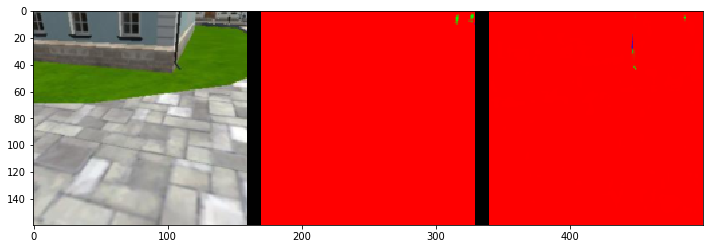

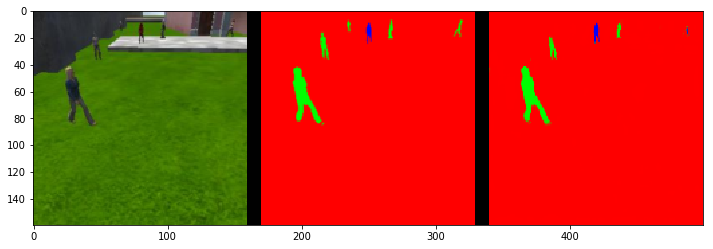

In [47]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [48]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9966645410628372
average intersection over union for other people is 0.4053506598357052
average intersection over union for the hero is 0.9202270107089459
number true positives: 539, number false positives: 0, number false negatives: 0


In [49]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9917055138651323
average intersection over union for other people is 0.8335565407302761
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 32, number false negatives: 0


In [50]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9974381062504207
average intersection over union for other people is 0.5148128214429345
average intersection over union for the hero is 0.37149500592237655
number true positives: 175, number false positives: 2, number false negatives: 126


In [51]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.816933638443936


In [52]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.645861008316


In [53]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.527625583452
